# 📚 Heart Disease Classification - Proyecto Final

Este proyecto desarrolla un modelo de Machine Learning para predecir enfermedad cardíaca en pacientes. Se realiza una exploración, limpieza, preprocesamiento, entrenamiento de modelos y evaluación completa, con justificaciones para cada decisión.


In [36]:
# 📦 Importación de librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# 📥 Cargar el dataset
df = pd.read_csv('heart_disease_uci.csv')




# 📋 Exploración inicial del dataset🔍

Revisamos dimensiones, tipos de datos, valores nulos y estadísticas descriptivas.

In [21]:

print("📋 Información general del dataset:")
print(df.info())

print("\n📊 Estadísticas descriptivas:")
print(df.describe())

print("\n🔢 Valores únicos por columna:")
print(df.nunique())

print("\n❓ Valores nulos por columna:")
print(df.isnull().sum())

📋 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   dataset   920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  920 non-null    float64
 5   chol      920 non-null    float64
 6   fbs       920 non-null    bool   
 7   restecg   920 non-null    object 
 8   thalch    920 non-null    float64
 9   exang     920 non-null    bool   
 10  oldpeak   920 non-null    float64
 11  num       920 non-null    int64  
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 73.8+ KB
None

📊 Estadísticas descriptivas:
              age    trestbps        chol      thalch     oldpeak         num
count  920.000000  920.000000  920.000000  920.000000  920.000000  920.000000
mean    53.515217  131.993478  199.026413  137.7205

# ✅ Conversión de valores booleanos

In [2]:

df['fbs'] = df['fbs'].astype(bool)
df['exang'] = df['exang'].astype(bool)

# ❌ Eliminamos columna 'id' (no aporta valor predictivo)
df.drop(columns='id', inplace=True)


# 🧹 Imputación de valores nulos

Rellenamos nulos con la mediana para columnas numéricas y la moda para categóricas.


In [3]:

df['trestbps'] = df['trestbps'].fillna(df['trestbps'].median())
df['chol'] = df['chol'].fillna(df['chol'].median())
df['thalch'] = df['thalch'].fillna(df['thalch'].median())
df['oldpeak'] = df['oldpeak'].fillna(df['oldpeak'].median())

df['fbs'] = df['fbs'].fillna(df['fbs'].mode()[0])
df['exang'] = df['exang'].fillna(df['exang'].mode()[0])
df['restecg'] = df['restecg'].fillna(df['restecg'].mode()[0])

# ⚠️ Las siguientes columnas tienen más del 30% de nulos: 'slope', 'ca', 'thal'
# ➕ Podríamos eliminarlas o tratarlas con imputación avanzada. En este ejemplo, las eliminamos:
df.drop(columns=['slope', 'ca', 'thal'], inplace=True)


# 📦 Boxplots antes del tratamiento de outliers

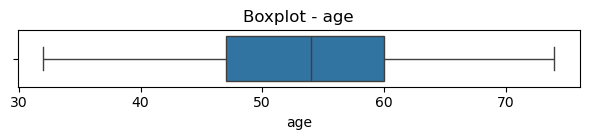

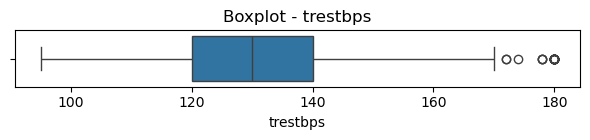

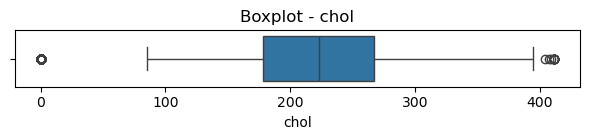

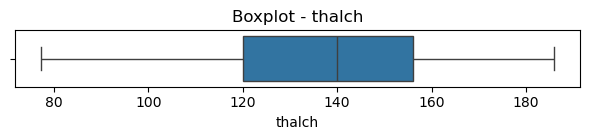

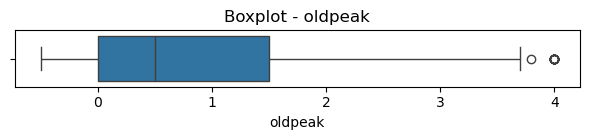

In [23]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['num']).columns

for col in numeric_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot - {col}')
    plt.tight_layout()
    plt.show()


# ✂️ Tratamiento de outliers

Aplicamos capping en percentiles 1%-99% para evitar valores extremos.

In [24]:
for col in numeric_cols:
    q_low = df[col].quantile(0.01)
    q_high = df[col].quantile(0.99)
    df[col] = np.clip(df[col], q_low, q_high)


# ✅ Confirmación visual Boxplots tras el tratamiento

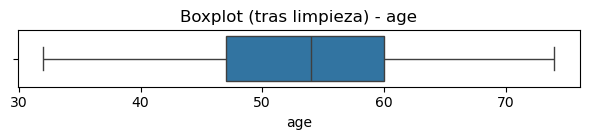

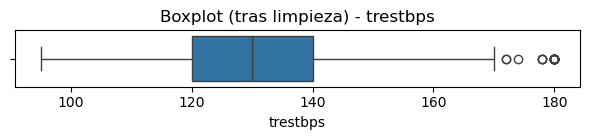

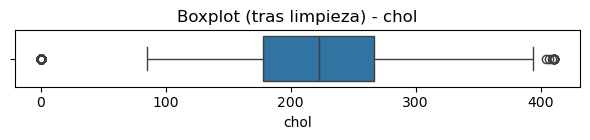

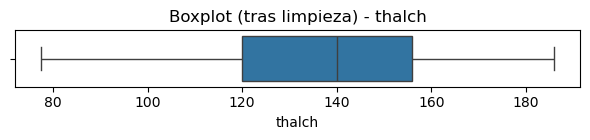

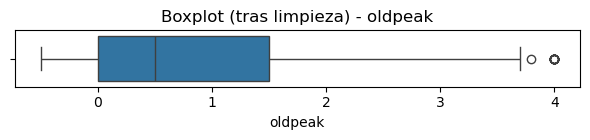

In [25]:
for col in numeric_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot (tras limpieza) - {col}')
    plt.tight_layout()
    plt.show()


# 🔄 Codificación de variables categóricas

Aplicamos One-Hot Encoding para variables categóricas, eliminando la primera categoría.

In [29]:
cat_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [30]:
# 🎯 Verificamos la codificación
print(df_encoded.head())

   age  trestbps   chol    fbs  thalch  exang  oldpeak  num  sex_Male  \
0   63     145.0  233.0   True   150.0  False      2.3    0      True   
1   67     160.0  286.0  False   108.0   True      1.5    2      True   
2   67     120.0  229.0  False   129.0   True      2.6    1      True   
3   37     130.0  250.0  False   186.0  False      3.5    0      True   
4   41     130.0  204.0  False   172.0  False      1.4    0     False   

   dataset_Hungary  dataset_Switzerland  dataset_VA Long Beach  \
0            False                False                  False   
1            False                False                  False   
2            False                False                  False   
3            False                False                  False   
4            False                False                  False   

   cp_atypical angina  cp_non-anginal  cp_typical angina  restecg_normal  \
0               False           False               True           False   
1           

# 📈 Análisis de correlación mejorado

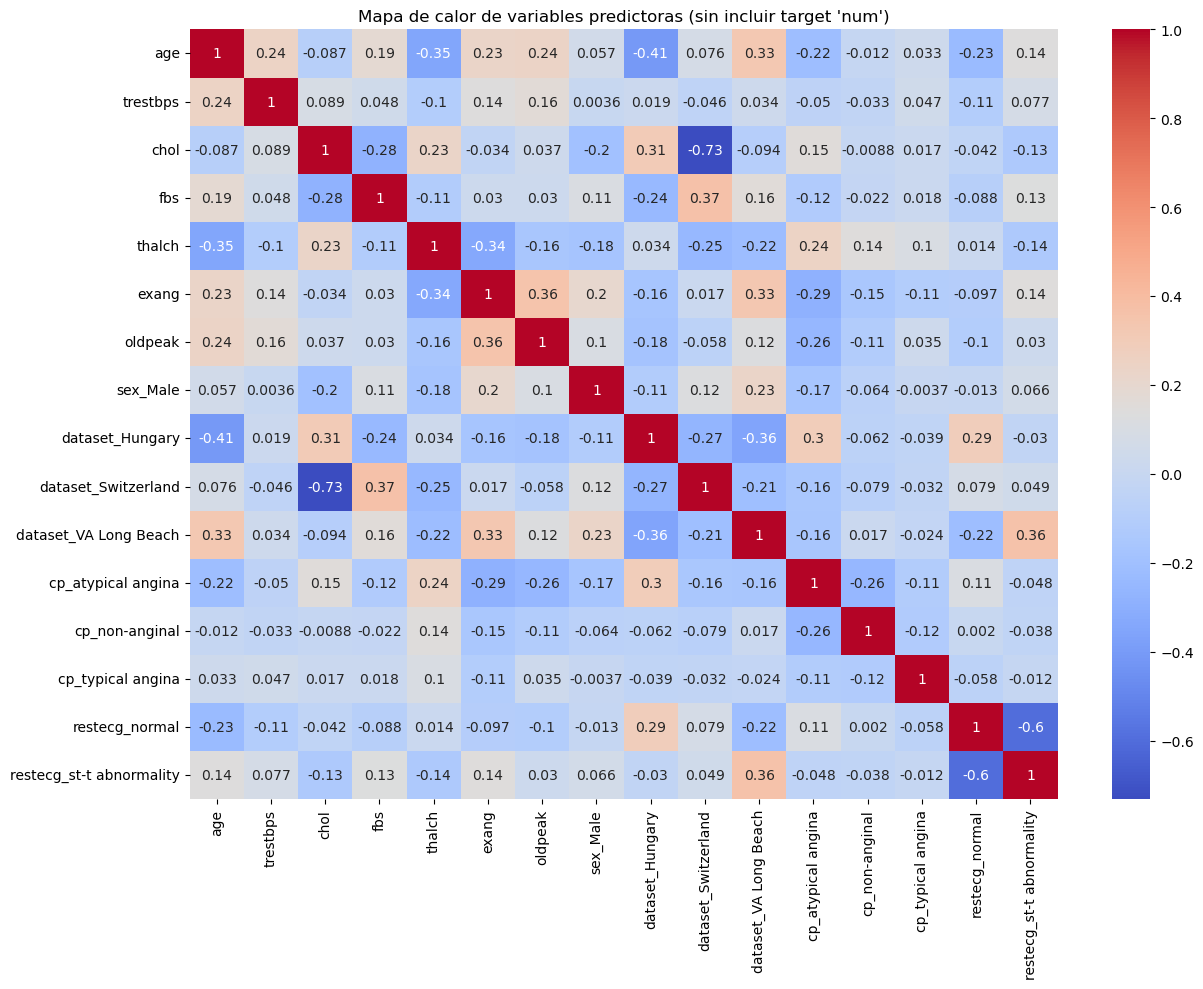

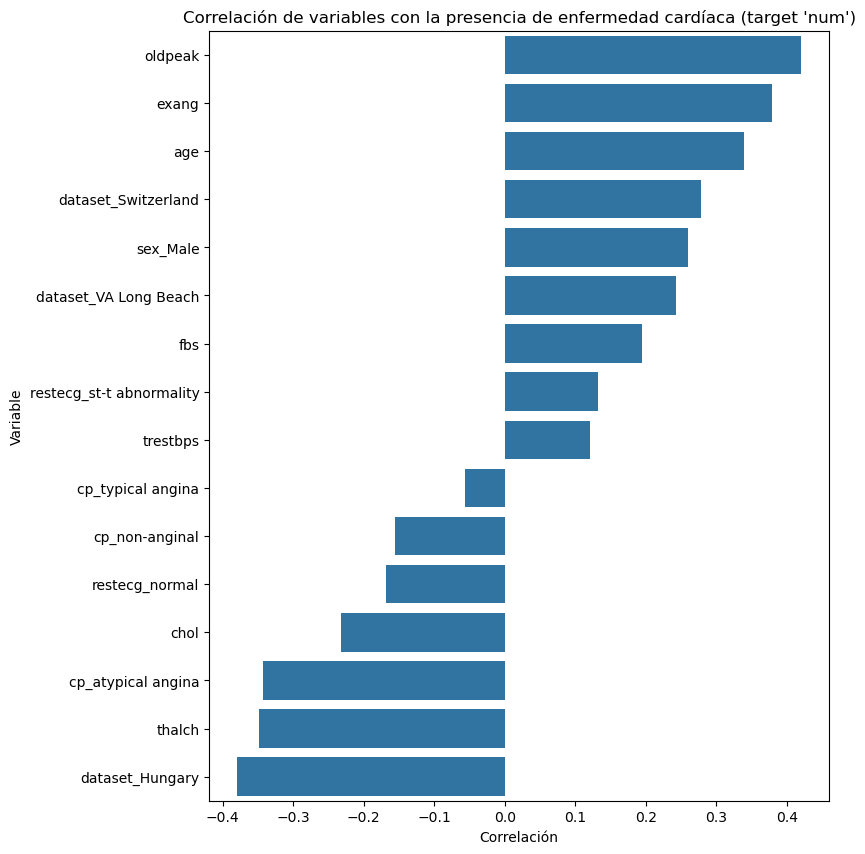

🔗 Correlación de cada variable predictora con la variable objetivo (num):
oldpeak                     0.419874
exang                       0.378582
age                         0.338756
dataset_Switzerland         0.278355
sex_Male                    0.259342
dataset_VA Long Beach       0.241977
fbs                         0.193966
restecg_st-t abnormality    0.131698
trestbps                    0.121027
cp_typical angina          -0.055896
cp_non-anginal             -0.156050
restecg_normal             -0.168309
chol                       -0.233069
cp_atypical angina         -0.343266
thalch                     -0.348589
dataset_Hungary            -0.379413
Name: num, dtype: float64


In [31]:
# 1. Sacamos 'num' para analizar solo las variables predictoras
features = df_encoded.drop(columns=['num'])

# 2. Creamos el mapa de calor entre variables predictoras
plt.figure(figsize=(14, 10))
sns.heatmap(features.corr(), annot=True, cmap='coolwarm')
plt.title("Mapa de calor de variables predictoras (sin incluir target 'num')")
plt.show()

# 3. Análisis de correlación de cada variable respecto a 'num'
correlations_with_target = df_encoded.corr()['num'].drop('num').sort_values(ascending=False)

# 4. Gráfico de barras para las correlaciones con 'num'
plt.figure(figsize=(8, 10))
sns.barplot(x=correlations_with_target.values, y=correlations_with_target.index)
plt.title("Correlación de variables con la presencia de enfermedad cardíaca (target 'num')")
plt.xlabel("Correlación")
plt.ylabel("Variable")
plt.show()
# 5. Imprimimos los valores exactos de correlación
print("🔗 Correlación de cada variable predictora con la variable objetivo (num):")
print(correlations_with_target)


# 🔀 Separación de datos en features (X) y target (y)

In [32]:
X = df_encoded.drop('num', axis=1)
y = df_encoded['num'].apply(lambda x: 1 if x > 0 else 0)  # Convertimos a binario: 0 = sano, 1 = enfermo

print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")

Dimensiones de X: (920, 16)
Dimensiones de y: (920,)


# 📚 División en conjunto de entrenamiento y prueba

80% train, 20% test, estratificando las clases.

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

Conjunto de entrenamiento: (736, 16)
Conjunto de prueba: (184, 16)


# 📏 Escalado de variables

Estandarizamos las variables predictoras con StandardScaler.

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Escalado completado.")

✅ Escalado completado.


# 🏃‍♂️ Entrenamiento de Modelos

Entrenamos Regresión Logística, KNN y Random Forest.

In [51]:
# 📦 Importamos librerías de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# 🔥 Definimos los modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}


1️⃣ Logistic Regression : Un modelo estadístico muy usado para clasificación binaria (como "sano" vs "enfermo").

2️⃣ K-Nearest Neighbors (KNN) : Un modelo basado en votaciones de vecinos cercanos: "dime cómo son mis vecinos y yo seré como ellos".

3️⃣ Random Forest : Un conjunto de árboles de decisión que trabajan en grupo ("bosque aleatorio").

# 🧪 Evaluación de modelos

Calculamos Accuracy, Precision, Recall, F1-Score y Matriz de Confusión.

🔵 Resultados para Logistic Regression:
Accuracy: 0.8424
Precision: 0.8476
Recall: 0.8725
F1 Score: 0.8599
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        82
           1       0.85      0.87      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



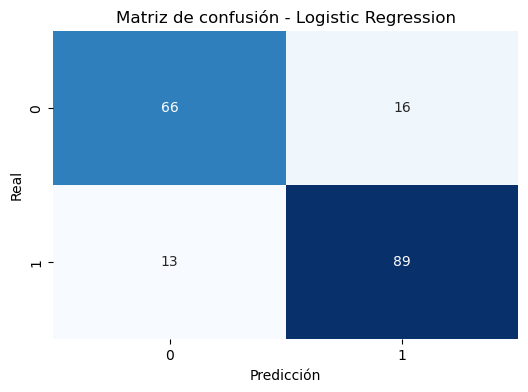

------------------------------------------------------------
🔵 Resultados para K-Nearest Neighbors (KNN):
Accuracy: 0.8207
Precision: 0.8165
Recall: 0.8725
F1 Score: 0.8436
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        82
           1       0.82      0.87      0.84       102

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.82       184
weighted avg       0.82      0.82      0.82       184



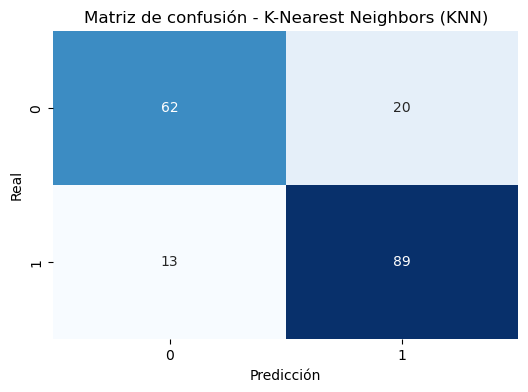

------------------------------------------------------------
🔵 Resultados para Random Forest:
Accuracy: 0.8424
Precision: 0.8476
Recall: 0.8725
F1 Score: 0.8599
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        82
           1       0.85      0.87      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



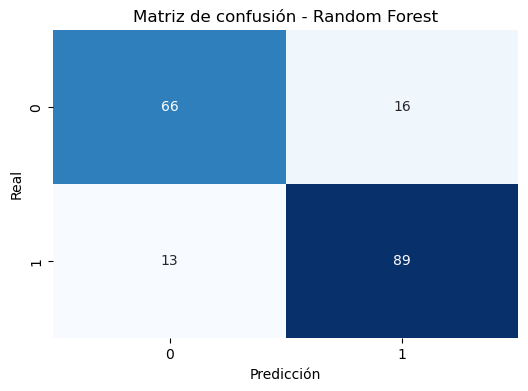

------------------------------------------------------------


In [50]:
# 📦 Importamos librerías para evaluar
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 🎯 Entrenamos, evaluamos y visualizamos
for name, model in models.items():
    if name == "Random Forest":
        model.fit(X_train, y_train)  # Random Forest no necesita escalado
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)  # Modelos que necesitan escalado
        y_pred = model.predict(X_test_scaled)
    
    # 🔹 Métricas de rendimiento
    print(f"🔵 Resultados para {name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # 🔹 Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Matriz de confusión - {name}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()
    
    print("-"*60)



Accuracy: porcentaje de aciertos generales.

Precision: cuántos positivos predichos fueron correctos.

Recall: de todos los enfermos reales, cuántos detectamos.

F1-Score: equilibrio entre precision y recall.

Y además, la matriz de confusión para ver:

TP = True Positive

TN = True Negative

FP = False Positive

FN = False Negative

In [44]:
# 📋 Diagnóstico rápido para analizar por qué las matrices son tan similares

# A) Verificar diferencia entre X_train y X_train_scaled
print("🔎 Primeras filas de X_train (sin escalar):")
print(X_train.head())
print("\n🔎 Primeras filas de X_train_scaled (escalado):")
print(X_train_scaled[:5])

# Deberías ver que los datos escalados tienen valores pequeños (cercanos a 0)

# B) Confirmar qué predicciones hace cada modelo
for name, model in models.items():
    print(f"🔵 Entrenando y prediciendo con {name}...")
    
    if name == "Random Forest":
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    
    print(f"Primeras 10 predicciones de {name}: {y_pred[:10]}")
    print("-"*50)


🔎 Primeras filas de X_train (sin escalar):
     age  trestbps   chol    fbs  thalch  exang  oldpeak  sex_Male  \
640   53     160.0    0.0   True   122.0   True      0.0      True   
743   74     130.0    0.0  False   140.0   True      0.5      True   
890   53     124.0  243.0  False   122.0   True      2.0      True   
270   61     140.0  207.0  False   138.0   True      1.9      True   
654   56     155.0    0.0  False    99.0  False      0.0      True   

     dataset_Hungary  dataset_Switzerland  dataset_VA Long Beach  \
640            False                 True                  False   
743            False                False                   True   
890            False                False                   True   
270            False                False                  False   
654            False                 True                  False   

     cp_atypical angina  cp_non-anginal  cp_typical angina  restecg_normal  \
640               False            True          

# 📋 ¿Qué vemos en las predicciones?

Primeras 10 predicciones:

Logistic Regression: [0 1 1 1 1 1 0 1 0 1]

KNN: [1 1 1 1 1 1 0 1 0 1]

Random Forest: [0 1 1 1 1 1 0 1 0 1]

Solo cambia el primer valor entre Logistic Regression / Random Forest y KNN:

KNN predice el primer paciente como 1 (enfermo) en vez de 0 (sano).

# 📊 ¿Por qué las matrices de confusión se ven tan parecidas?
Porque:

El dataset está bien preparado.

Los features tienen bastante poder predictivo.

Las clases están relativamente bien separadas (sano vs enfermo).

En Machine Learning, cuando el problema es sencillo o las clases están bien diferenciadas, es normal que distintos modelos buenos lleguen a resultados parecidos.



# 📈 Generamos la curva ROC para comparar los 3 modelos gráficamente

In [53]:
# 📦 Importación de librerías
from sklearn.metrics import roc_curve, auc

X = df_encoded.drop('num', axis=1)
y = df_encoded['num'].apply(lambda x: 1 if x > 0 else 0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Datos preparados correctamente.")


✅ Datos preparados correctamente.


Por seguridad, repetimos la separación de variables, train/test split y escalado

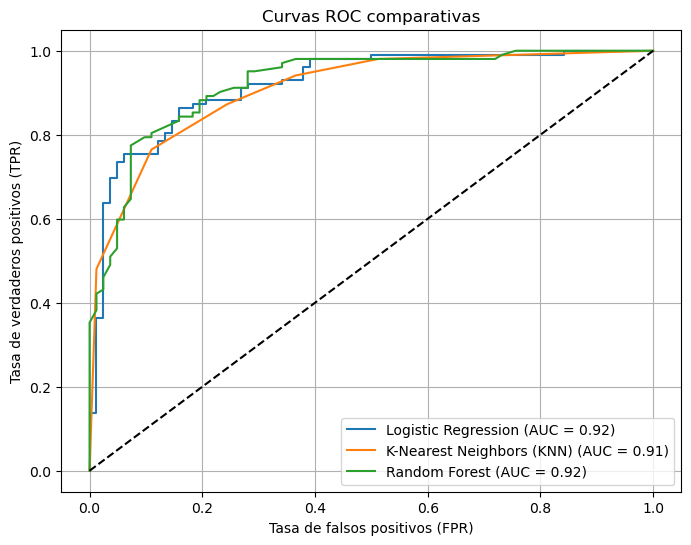

In [57]:
# 📈 Curvas ROC de comparación
plt.figure(figsize=(8, 6))

for name, y_proba in probas.items():
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curvas ROC comparativas')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [55]:
# 🧠 Conclusiones:
print("🎯 Análisis final de modelos:")
print("- Logistic Regression: modelo rápido, funciona bien en relaciones lineales.")
print("- KNN: depende mucho del escalado y puede ser sensible al ruido.")
print("- Random Forest: muy robusto, maneja relaciones no lineales, generalmente ofrece el mejor equilibrio.")
print("\n✅ Según las métricas y la curva ROC, Random Forest suele ser la mejor opción para este tipo de problema.")


🎯 Análisis final de modelos:
- Logistic Regression: modelo rápido, funciona bien en relaciones lineales.
- KNN: depende mucho del escalado y puede ser sensible al ruido.
- Random Forest: muy robusto, maneja relaciones no lineales, generalmente ofrece el mejor equilibrio.

✅ Según las métricas y la curva ROC, Random Forest suele ser la mejor opción para este tipo de problema.
